In [1]:
from emergent_models.core.state import StateModel
from emergent_models.rules.sanitization import lut_idx
from emergent_models.core.space_model import Tape1D
from emergent_models.encoders.em43 import Em43Encoder
from emergent_models.simulation.simulator import Simulator
from emergent_models.training import (AbsoluteDifferenceFitness, Trainer,
                                      ComplexityRewardFitness,
                    SparsityPenalizedFitness, GAOptimizer)
from emergent_models.training import TqdmMonitor, DetailedMonitor, CombinedMonitor
from tqdm.notebook import tqdm
import numpy as np


In [39]:

print("🔬 Setting up investigation...")

# ═══════════════════ HYPERPARAMETERS ═══════════════════
POP_SIZE      = 500
BATCH_SIZE    = 30
N_GENERATIONS = 30
ELITE_FRAC    = 0.1
TOURNEY_K     = 3
P_MUT_RULE    = 0.03
P_MUT_PROG    = 0.08
L_PROG        = 10
LAMBDA_P      = 0.01
EPS_RANDOM_IMMIGRANTS = 0.02
N_COMPLEX_TELEMETRY   = 5
INPUT_SET     = np.arange(1, 31, dtype=np.int64)
TARGET_OUT    = 2 * INPUT_SET
WINDOW        = 200
MAX_STEPS     = 800
HALT_THRESH   = 0.50
CHECK_EVERY   = 50


# 1. Domain setup
_IMMUTABLE = {
    lut_idx(0, 0, 0): 0,  # Empty space stays empty
    lut_idx(0, 2, 0): 2,  # Red beacon propagation
    lut_idx(0, 0, 2): 0,  # Red beacon boundary
    lut_idx(2, 0, 0): 0,  # Red beacon boundary  
    lut_idx(0, 3, 3): 3,  # Blue boundary behavior
    lut_idx(3, 3, 0): 3,  # Blue boundary behavior
    lut_idx(0, 0, 3): 0,  # Blue boundary behavior
    lut_idx(3, 0, 0): 0,  # Blue boundary behavior
}
state = StateModel([0,1,2,3], immutable=_IMMUTABLE)
space = Tape1D(length=WINDOW, radius=1)
encoder = Em43Encoder(state, space)


# 2. Simulation
sim = Simulator(
    state=state, 
    space=space, 
    max_steps=MAX_STEPS,                                    # MAX_STEPS
    halt_thresh=HALT_THRESH                                 # HALT_THRESH
)

# Usage
base_fitness = AbsoluteDifferenceFitness(continuous=True)

fitness = ComplexityRewardFitness(
    base_fitness, 
    complexity_bonus=0.05
)


# Combine tqdm with detailed logging
tqdm_monitor = TqdmMonitor(N_GENERATIONS)
detailed_monitor = DetailedMonitor(log_every=10, detailed_every=30)
combined = CombinedMonitor(tqdm_monitor, detailed_monitor)

# 4. Optimizer with all GA parameters
optim = GAOptimizer(
    pop_size=POP_SIZE,                                      # POP_SIZE
    state=state,
    prog_len=L_PROG,                                        # L_PROG
    mutation_rate=P_MUT_RULE,                               # P_MUT_RULE
    prog_mutation_rate=P_MUT_PROG,                          # P_MUT_PROG
    elite_fraction=ELITE_FRAC,                              # ELITE_FRAC
    tournament_size=TOURNEY_K,                              # TOURNEY_K
    random_immigrant_rate=EPS_RANDOM_IMMIGRANTS,            # EPS_RANDOM_IMMIGRANTS
    prog_sparsity=0.3
)

# 3. Training
trainer = Trainer(encoder, sim, fitness, optim, combined)



print("✅ Setup complete!")


🔬 Setting up investigation...
🚀 Pre-allocated evaluation buffers: pop_size=500, table_size=64, prog_len=10
✅ Setup complete!


In [40]:
print("🚀 Starting training with tqdm progress bar...")
inputs = np.random.randint(1, 30, size=BATCH_SIZE).reshape(-1, 1)
targets = 2 * inputs
print(inputs.shape, targets.shape)


🚀 Starting training with tqdm progress bar...
(30, 1) (30, 1)


####
# Preparing Initial State from Input Data
###

input data dims: batch_size x single_inp_dim (B, D1, D2, ...)
Let's focus on 1-D inputs for now.
then input data dims: batch_size x single_inp_dim (B, D1)

program dim for 1-D tape: population_size x programme_length (P, L)
Tape dims: population_size x tape_length (P, T) where T > D1 + L + offset


Ideally, the encoded training data should have dims: (B, P, T)
For simplicity let's make batch is implicitly the population size.
so, the training input should have dims: (P, T)



In [41]:
population = trainer.optimizer.ask()
population[:3]

[Genome(rule_size=64, prog_length=10, fitness=0.0000),
 Genome(rule_size=64, prog_length=10, fitness=0.0000),
 Genome(rule_size=64, prog_length=10, fitness=0.0000)]

In [42]:
population[0].programme.code

array([0, 2, 0, 1, 0, 1, 0, 0, 0, 0], dtype=uint8)

In [43]:

def _extract_population_data_fast(genomes) -> tuple[np.ndarray, np.ndarray]:
    """
    Fast extraction of population data into pre-allocated buffers.

    This method optimizes the data extraction bottleneck by minimizing
    Python loops and using vectorized operations where possible.
    """
    
    prog_len = L_PROG

    # Determine rule table size (assumes 4-state, 3-neighborhood = 64 entries)
    n_states = state.n_states
    table_size = n_states ** 3
    pop_size = len(genomes)
    _rule_buffer = np.zeros((pop_size, table_size), dtype=np.uint8)
    _prog_buffer = np.zeros((pop_size, prog_len), dtype=np.uint8)
    # Extract rule tables and programmes in optimized loop
    for i in range(pop_size):
        # Direct array assignment (faster than individual element access)
        np.copyto(_rule_buffer[i], genomes[i].rule.table)
        np.copyto(_prog_buffer[i], genomes[i].programme.code)
    return _rule_buffer, _prog_buffer

def _lut_idx(left, center, right):
    return (left << 4) | (center << 2) | right

def step_1d(tape, rule_table):
    length = len(tape)
    next_tape = np.zeros(length, dtype=np.uint8)
    
    # Boundary cells stay 0
    next_tape[0] = 0
    next_tape[length-1] = 0
    
    # Apply rules to interior cells
    for x in range(1, length - 1):
        left = tape[x - 1]
        center = tape[x]
        right = tape[x + 1]
        
        # Lookup table index
        idx = (left << 4) | (center << 2) | right
        if idx < len(rule_table):
            next_tape[x] = rule_table[idx]
    return next_tape

In [44]:
rules, progs = _extract_population_data_fast(population)

In [45]:
inputs.shape

(30, 1)

In [46]:
# Encode 1D inputs along with programmes. P x B x T: population size x batch size x tape length
encoded_data = encoder.encode_population(progs, inputs)

In [47]:
encoded_data.shape

(500, 30, 200)

In [48]:
inputs[:4]

array([[14],
       [ 5],
       [29],
       [16]])

In [49]:
# Check if the decoding works
decoded_data = encoder.decode_population(encoded_data, L_PROG)

In [50]:
print(decoded_data.shape, decoded_data[0, :4])

(500, 30) [14  5 29 16]


In [51]:
final_state = sim.run_batch(encoded_data, rules)


In [52]:
final_decoded_data = encoder.decode_population(final_state, L_PROG)
final_decoded_data[0]

array([14,  5, 29, 16, 20,  9,  5, 13,  1, 23,  2, 27,  3,  2, 20, 19,  9,
       22, 12, 17, 16, 11, 22, 14, 27, 20, 27,  5, 26,  2], dtype=int32)

Let's take a look inside how the simulator works:

In [53]:
batch_idx = 0
population_idx = 1
single_input = inputs[batch_idx]
single_tape = encoded_data[population_idx, batch_idx] # single programme (first genome), single input
print("Input: ",single_input)
print("INITIAL: Encoded tape state: ", "".join(map(str, single_tape)))
print("Rule set applied: ", rules[population_idx])
for step in range(10):
    single_tape = step_1d(single_tape, rules[population_idx])
    print(f"STEP: {step+1:2d}\t Encoded tape state: ", "".join(map(str, single_tape)))
    # We need to add a dummy dimension for population size
    print(f"STEP: {step+1:2d}\t Interim decoded state: ", encoder.decode(single_tape[None, :], L_PROG))
    if sim._check_halt(single_tape):
        live_count = np.count_nonzero(single_tape)
        if live_count == 0:
            print("HALTED (no live cells)")
        
        blue_count = np.count_nonzero(single_tape == 3)
        blue_fraction = blue_count / live_count
        print(f"Blue count (3):{blue_count}\nlive count (non-zero):{live_count}\nblue fraction (blue/live):{blue_fraction:.3f} ")
        print("HALTED")
        break

Input:  [14]
INITIAL: Encoded tape state:  00000220203300000000000000020000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Rule set applied:  [0 1 0 0 1 2 0 0 2 3 1 1 2 2 0 3 3 2 0 1 0 3 1 3 1 2 2 3 3 2 1 3 0 0 3 0 2
 3 2 0 3 0 1 2 0 2 2 0 0 2 0 0 3 1 0 2 0 1 3 1 3 1 1 0]
STEP:  1	 Encoded tape state:  00000133203300000000000000020000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
STEP:  1	 Interim decoded state:  [14]
Blue count (3):4
live count (non-zero):7
blue fraction (blue/live):0.571 
HALTED


In [54]:
idx = _lut_idx(2, 1, 0)
rules[batch_idx][idx]

np.uint8(0)

In [55]:
from typing import Optional
from emergent_models.visualization.progression import ProgressionVisualizer
from emergent_models.visualization.tape import TapeVisualizer
from matplotlib import pyplot as plt

In [56]:

# Set up matplotlib for Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

def debug_single_genome_evolution(programme: np.ndarray, 
                                 input_val: int,
                                 rule_table: np.ndarray,
                                 max_steps: int = 20,
                                 halt_thresh: float = 0.5,
                                 window_size: int = 50,
                                 zoom_range: Optional[tuple] = None,
                                 show_step_by_step: bool = True):
    """
    Debug single genome CA evolution with step-by-step visualization.
    
    Parameters
    ----------
    programme : np.ndarray
        Programme array (e.g., [1, 2, 1])
    input_val : int
        Input value to encode
    rule_table : np.ndarray
        64-element rule lookup table
    max_steps : int, default=20
        Maximum simulation steps
    halt_thresh : float, default=0.5
        Halting threshold (fraction of blue cells)
    window_size : int, default=50
        CA tape window size
    zoom_range : tuple, optional
        (start, end) positions to focus on
    show_step_by_step : bool, default=True
        Whether to show individual step visualizations
    """
    
    print("🔬 CA Evolution Debugger")
    print("=" * 50)
    
    state = StateModel([0,1,2,3], immutable=_IMMUTABLE)
    space = Tape1D(window_size, radius=1)
    encoder = Em43Encoder(state, space)
    simulator = Simulator(state=state, space=space, max_steps=max_steps, halt_thresh=halt_thresh)
    
    # Create visualizers
    tape_viz = TapeVisualizer(state, backend="matplotlib")
    prog_viz = ProgressionVisualizer(state, backend="matplotlib")
    
    print(f"📝 Programme: {programme}")
    print(f"📥 Input: {input_val}")
    print(f"🎯 Rule table (first 10): {rule_table[:10]}...")
    print(f"⏱️  Max steps: {max_steps}")
    print(f"🛑 Halt threshold: {halt_thresh}")
    print()
    
    # Encode initial tape
    initial_tape = encoder.encode(programme, input_val)[0]
    print(f"🎬 Initial tape (first 20 cells): {initial_tape[:20]}")
    
    # Calculate expected positions
    prog_len = len(programme)
    separator_pos = prog_len + 2
    beacon_pos = prog_len + 2 + input_val + 1
    print(f"📍 Programme: [0:{prog_len}], Separator: [{prog_len}:{separator_pos}], Beacon: {beacon_pos}")
    print()
    
    # Run step-by-step simulation
    evolution_history = []
    current_tape = initial_tape.copy()
    evolution_history.append(current_tape.copy())
    
    halted = False
    halt_step = None
    
    print("🚀 Starting simulation...")
    for step in range(max_steps):
        # Apply one CA step
        next_tape = simulator._step_kernel(current_tape, rule_table)
        evolution_history.append(next_tape.copy())
        
        # Check halting condition
        blue_count = np.count_nonzero(next_tape == 3)
        live_count = np.count_nonzero(next_tape)
        
        if live_count > 0:
            blue_fraction = blue_count / live_count
            print(f"Step {step+1:2d}: Live={live_count:2d}, Blue={blue_count:2d}, Fraction={blue_fraction:.3f}", end="")
            
            if blue_fraction >= halt_thresh:
                print(" 🛑 HALTED!")
                halted = True
                halt_step = step + 1
                break
            else:
                print()
        else:
            print(f"Step {step+1:2d}: All cells dead ☠️")
            break
        
        current_tape = next_tape
    
    print()
    if halted:
        print(f"✅ Simulation halted at step {halt_step}")
    else:
        print(f"⏰ Simulation completed without halting ({len(evolution_history)-1} steps)")
    
    # Show individual step visualizations
    if show_step_by_step and len(evolution_history) <= 10:
        print("\n📊 Step-by-step tape states:")
        fig, axes = plt.subplots(min(len(evolution_history), 5), 1, figsize=(15, 2*min(len(evolution_history), 5)))
        if len(evolution_history) == 1:
            axes = [axes]
        
        for i, tape in enumerate(evolution_history[:5]):  # Show first 5 steps
            ax = axes[i] if i < len(axes) else None
            if ax is not None:
                # Create simple bar visualization
                colors = ['black', 'white', 'red', 'blue']
                tape_colors = [colors[state] for state in tape[:30]]  # Show first 30 cells
                
                ax.bar(range(len(tape_colors)), [1]*len(tape_colors), color=tape_colors, 
                      edgecolor='gray', linewidth=0.5)
                ax.set_title(f"Step {i}")
                ax.set_xlim(-0.5, len(tape_colors)-0.5)
                ax.set_ylim(0, 1)
                ax.set_ylabel('State')
                
                # Add annotations
                ax.axvline(prog_len-0.5, color='green', alpha=0.7, linestyle='--', label='Prog End')
                ax.axvline(separator_pos-0.5, color='orange', alpha=0.7, linestyle='--', label='Sep End')
                ax.axvline(beacon_pos, color='purple', alpha=0.7, linestyle='-', linewidth=2, label='Beacon')
                
                if i == 0:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    # Create 2D space-time visualization
    print("\n🎨 2D Space-Time Evolution Map:")
    
    # Apply zoom if specified
    display_range = zoom_range if zoom_range else (0, min(50, len(initial_tape)))
    
    fig = prog_viz.render(
        evolution_history,
        title=f"CA Evolution: Programme={programme}, Input={input_val}",
        prog_len=prog_len,
        input_val=input_val,
        zoom_range=display_range,
        show_annotations=True,
        figsize=(15, 8)
    )
    
    plt.show()
    
    # Decode final output
    final_tape = evolution_history[-1]
    decoded_output = encoder.decode(final_tape[None, :], prog_len)
    expected_output = input_val * 2  # For doubling task
    
    print(f"\n🎯 Results:")
    print(f"   Input: {input_val}")
    print(f"   Decoded output: {decoded_output}")
    print(f"   Expected (2×input): {expected_output}")
    print(f"   Correct: {'✅' if decoded_output == expected_output else '❌'}")
    
    return evolution_history, decoded_output


🔬 CA Evolution Debugger
📝 Programme: [2 1 0 0 0 0 0 0 1 0]
📥 Input: [14]
🎯 Rule table (first 10): [0 2 0 0 3 2 1 3 2 3]...
⏱️  Max steps: 20
🛑 Halt threshold: 0.5

🎬 Initial tape (first 20 cells): [2 1 0 0 0 0 0 0 1 0 3 3 0 0 0 0 0 0 0 0]
📍 Programme: [0:10], Separator: [10:12], Beacon: [27]

🚀 Starting simulation...
Step  1: Live= 7, Blue= 4, Fraction=0.571 🛑 HALTED!

✅ Simulation halted at step 1

📊 Step-by-step tape states:


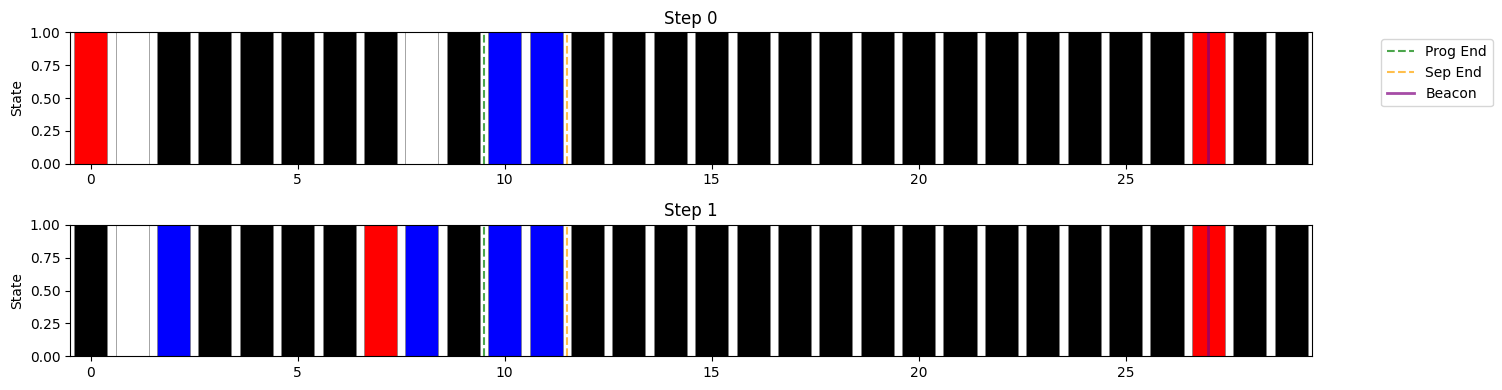


🎨 2D Space-Time Evolution Map:


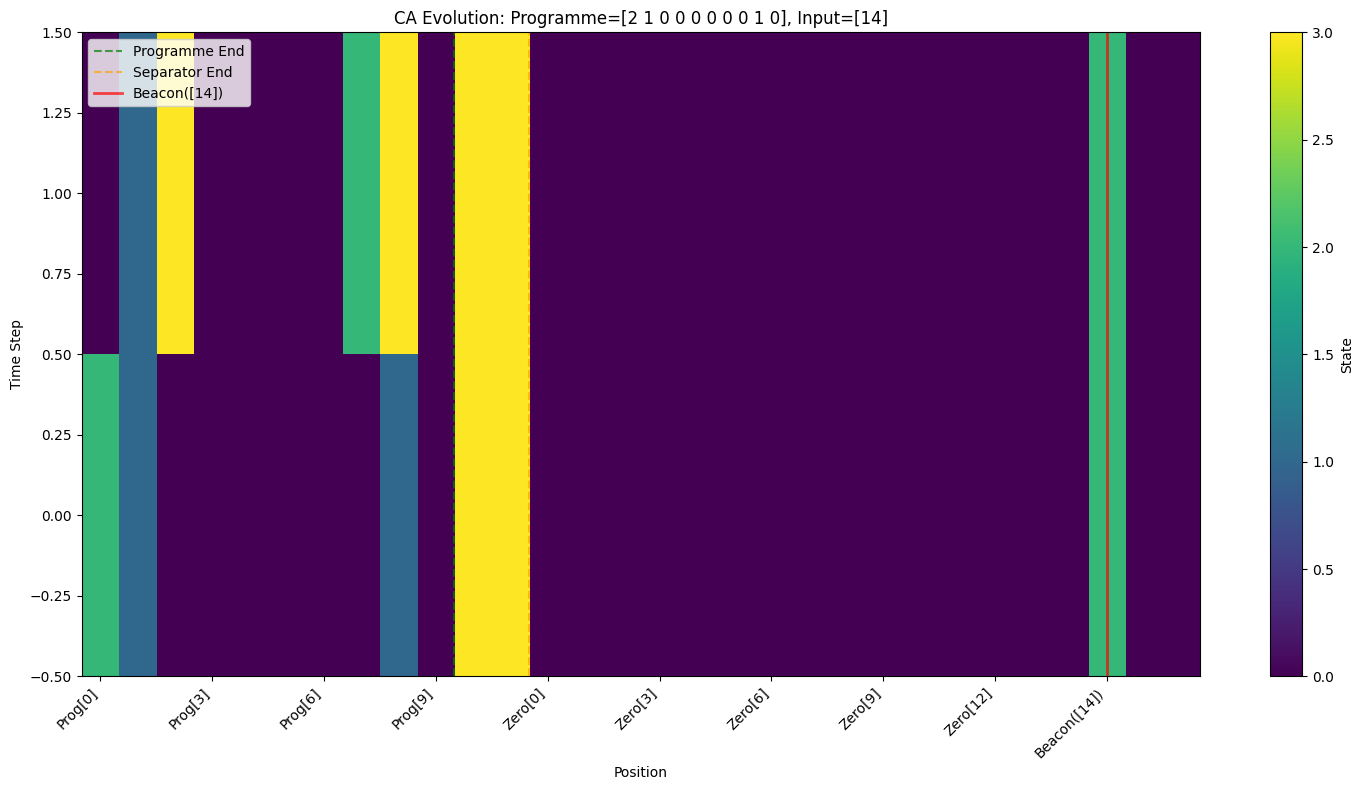


🎯 Results:
   Input: [14]
   Decoded output: [14]
   Expected (2×input): [28]
   Correct: ❌


In [57]:
population_idx = 10
batch_idx = 0
# 3. Run the cell to see the visualization
history, output = debug_single_genome_evolution(
    programme=progs[population_idx],
    input_val=inputs[batch_idx], 
    rule_table=rules[population_idx],
    max_steps=20,
    zoom_range=(0, 30)  # Focus on first 30 cells
)

In [58]:

# This should now show a nice progress bar!
result = trainer.fit(
    inputs=inputs,  # Smaller input set for demo
    targets=targets,
    generations=N_GENERATIONS,           # Fewer generations for demo
    use_tqdm=False,          # Don't add another tqdm (we already have one in monitor)
    checkpoint_every=CHECK_EVERY,
    early_stopping_threshold=None
)

print(f"✅ Training completed! Best fitness: {result['best_fitness']:.4f}")

Starting training for 30 generations...
Population size: 500
Checkpointing every 50 generations to checkpoints/


Training:   0%|          | 0/30 [00:00<?, ?gen/s]

Gen    0: Best=0.9602, Mean=0.8985±0.1154, Time=0.0s

📊 DETAILED TELEMETRY - Generation 0
Fitness: Best=0.960180, Mean=0.898485, Std=0.115404
Performance: 0.00 gen/sec, Improvement=0.000000/gen
Accuracy: 0.00% of outputs match targets

Gen   10: Best=0.9602, Mean=0.9086±0.0787, Time=34.0s
Gen   20: Best=0.9602, Mean=0.8877±0.1341, Time=92.7s
🔍 DEBUG: Training loop completed. Final gen = 29, requested generations = 30
🔍 DEBUG: Saving final checkpoint. gen = 29, generations = 30
💾 Checkpoint saved: checkpoints/final_checkpoint.pkl
✅ Training completed! Best fitness: 0.9641


In [29]:
population = trainer.optimizer.ask()

In [ ]:
# Define test inputs and expected targets
test_inputs = np.array([1, 2, 3, 4, 5, 10, 15, 20], dtype=np.int64)
test_targets = 2 * test_inputs  # For doubling task


best_genome = trainer.optimizer.best_genome()
# Evaluate the best genome on test inputs
outputs = trainer.evaluate_single_genome(best_genome, test_inputs)
outputs = outputs.squeeze()
# Calculate accuracy
accuracy = np.mean(outputs == test_targets) * 100.0

In [54]:
# Print results
print(f"🧪 Testing best genome on {len(test_inputs)} inputs:")
print(f"Accuracy: {accuracy:.2f}%")
print("\nDetailed results:")
print("Input | Expected | Actual | Correct")
print("----- | -------- | ------ | -------")
for i, (inp, target, output) in enumerate(zip(test_inputs, test_targets, outputs)):
    correct = "✓" if output == target else "✗"
    print(f"{inp:5d} | {target:8d} | {output:6d} | {correct}")

🧪 Testing best genome on 8 inputs:
Accuracy: 0.00%

Detailed results:
Input | Expected | Actual | Correct
----- | -------- | ------ | -------
    1 |        2 |      1 | ✗
    2 |        4 |      2 | ✗
    3 |        6 |      3 | ✗
    4 |        8 |      4 | ✗
    5 |       10 |      5 | ✗
   10 |       20 |     10 | ✗
   15 |       30 |     15 | ✗
   20 |       40 |     20 | ✗



🔍 Detailed visualization for input 1:
Decoded output: 1
Expected output: 2


In [44]:
test_targets

array([ 2,  4,  6,  8, 10, 20, 30, 40])